## The Problem

Bellhops is a startup moving company that contracts movers and truck drivers to provide a high-quality, on-demand moving experience.  One of the company's logistical challenges is figuring out how long a move should be scheduled for. The company does not want to ovestimate how long a move will take because that will deter customers from booking, and if they do book, will unessesarily tie up resources. The company does not want to underestimate move length because if a move goes over the estimated time, because that can cause back ups throughout the rest of the day. 

Bellhops has two main types of move, or "broad move types": Full Service (FS) and Labor Only (LO.) On LO moves, bellhops only provides movers, typically 2-3. On FS moves, Bellhops provides a truck and typically 2-4 movers. Generally speaking, for a given move, the move movers you assign to the move, the shorter the time between reservation start at clock out, or "move length." Because drivers are paid a higher hourly rate than movers, stacking several shorter moves with more movers is more economical than scheduling longer moves with more drivers and fewer movers. In general, Bellhops would like to schedule moves so they are completed in under three hours. This would let Bellhops schedule a driver on 2-3 moves a day. However, 70% of FS moves are scheduled with 2 movers and roughly 50% of FS moves last longer than 3 hours. 

In addition to descreasing driver related costs, Bellhops has found that for a given number of man hours worked, the average NPS score can increase by 20% and average poor experience discounts decrease by 50% when 3 movers are on a FS job instead of 2.

If Bellhops could better predict whether or not a move was going to exceed the three-hour mark, Bellhops could simply schedule more movers, thereby improving the customer experience and increasing the company's margin.

## Data

The data come from Bellhops’ internal data warehouse. For each move the company performs, it collects the following features:

Order Number - the internal id for the move

Market - the city in which the move took place

FS - whether or not the move was a "Full Service" move, a move for which bellhops provided a driver and a truck. These are almost always multi-location moves. Non-full service moves are "Labor Only," moves where bellhops only provides labor. Labor only moves can be single or multication.

Move Type - the type of move

Move Length Hours - the time between reservation start and the last clock out

Phone - dummy variable that equals one when the move was booked on the phone and zero when booked online

Executed Man Hours - the number of man hours it took to complete the move

Booked Man Hours - the number of man hours that were booked

Order Total Spots - the number of movers that worked on the order

House - whether or not the property type was a house

Residence - whether or not the property was a residence

Rooms - the number of rooms on the property

Coupon Amount - the value of the customer's coupon, if present

GRPN - whether or not the move was from Groupon

Num Effort Hops - the number of hops that had previousely received poor effort ratings from customers

Some Inventory - whether or not he customer provided us with any inventory during the booking process

"Beds" through "Boxes" - the number of the named items the customer reported

Reservation Start - the datetime at which the reservation was scheduled to start

Booked At - the date time at which the order was booked

Dense - whether or not the order occurred in a market with more that 10k people per sq. mile

Flights of Stairs - the total number of flights of stairs for all properties on the move

Large/Medium/Small Items - the number of "large"/"medium"/"small" items reported during the booking process

Stops - the number of locations on the move

Elevators - the number of elevators reported during the booking porcess

Additional Instructions - whether or not the customer reported additional instructions during the booking process

NPS - net promoter score

Num Bad Star Hops - the number of hops on the job with previous low overall reviews

Avg Prev Late Rate - the average of the movers' rates of being late on previous moves

Sum Prev Late Rate - the sum of the movers' rates of being late on previous moves

Max Late Clock In Hours - the latest any mover was to the move in hours

Sum Late Clock In Hours - the total number of man hours that movers were late to the move

City Pop - the population of the market

Pop Density - the population density of the market

## Data Cleaning

#### Setting Up
First, I imported pandas so I could work with this data as a DataFrame and numpy for feature engineering. I read the csv into a pandas DataFrame, with column ‘order_id’ as the index. 


In [725]:
import pandas as pd
import numpy as np

#Read csv into a pandas dataframe.
csv = 'move_length.csv'
df = pd.read_csv(csv, index_col = 'order_id')
df.head()

,market,move_type,fs,move_length_hours,executed_man_hours,booked_man_hours,order_total_spots,property_size_name,property_type_name,house,...,nps_promoter,nps_detractor,num_bad_star_hops,avg_prev_late_rate,sum_prev_late_rate,max_late_clock_in_hours,sum_late_clock_in_hours,phone,city_pop,pop_density
order_id,,,,,,,,,,,,,,,,,,,,,
482733,atlantaga,gopher,1,3.666667,7.50,8.0,2,1 Bedroom,Apartment/Condo,0,...,1.0,0.0,2,0.094274,0.282823,0.000000,0.000000,1,472522.0,5180.0
483964,atlantaga,atob,0,2.369167,5.25,4.0,2,Studio/Loft,Apartment/Condo,0,...,1.0,0.0,3,0.113870,0.341611,0.000000,0.000000,0,472522.0,5180.0
484309,atlantaga,gopher,1,5.066667,10.50,8.0,2,1 Bedroom,Apartment/Condo,0,...,NaN,NaN,3,0.122590,0.490359,0.000000,0.000000,0,472522.0,5180.0
484339,atlantaga,unloading,0,0.687500,2.00,4.0,2,1 Bedroom,Apartment/Condo,0,...,1.0,0.0,2,0.171529,0.343058,0.000000,0.000000,0,472522.0,5180.0
484509,atlantaga,gopher,1,2.565556,5.50,4.0,2,1 Bedroom,Apartment/Condo,0,...,NaN,NaN,5,0.113659,0.795613,0.016667,0.016667,0,472522.0,5180.0


In [726]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8286 entries, 482733 to 552059
Data columns (total 55 columns):
market                       8286 non-null object
move_type                    8286 non-null object
fs                           8286 non-null int64
move_length_hours            8286 non-null float64
executed_man_hours           8286 non-null float64
booked_man_hours             8286 non-null float64
order_total_spots            8286 non-null int64
property_size_name           8286 non-null object
property_type_name           8286 non-null object
house                        8286 non-null int64
residence                    8286 non-null int64
rooms                        8286 non-null int64
coupon_amount                8286 non-null float64
min_billable_man_hours       8286 non-null int64
damage_cost                  8286 non-null float64
damage                       8286 non-null int64
appeasement                  8286 non-null int64
appeasement_cost             8286 non-n

#### Removing Extraneous Rows
Furthermore, I dropped about 20 rows out of 8,000 where the ‘move_length_hours’ column was null or less than 0. (There is clearly an issue with the data if it says the start time was after the end time.) As the independent variable is based on this column, it made no sense to replace values.

I removed less than 10 rows that were for moves of a depricated move type called "loadingorunloading" that was a stand-in used when it was unkown whether the move was actually of type "loading" or "unloading." 


In [727]:
#Drop rows where move_length_hours is null.(This is the column from which the independant variable is calculated.)
df = df[df['move_length_hours'].notnull()]
df = df[df['move_length_hours'] > 0]

In [728]:
#Drop rows where move_type is 'loadingorunloading.' This is a depricated move type that shows up vary rarely in this dataset and would not help with predictions.
df = df[df['move_type'] != 'loadingorunloading']

In [729]:
#Drop rows where move_type is 'packing.' This is an experimental move type Bellhops only offers intermitantly. 
df = df[df['move_type'] != 'packing']

#### Filling Nulls
For single-location moves that were booked after we started collecting the drive distance/time between move locations, I replaced null values for drive distance/time with 0 minutes/miles. I aslo added a columns for drive hours between moves.

In [730]:
#Fill in rows for single stop moves after drive distance/time existed with 0 minutes/miles
first_drive_record = np.min(df['reservation_start'][df['minutes_between_waypoints'].notnull()])

df['minutes_between_waypoints'] = np.where((df.reservation_start >= first_drive_record) & (df.stops == 1),0,df.minutes_between_waypoints)

df['hours_between_waypoints'] = df['minutes_between_waypoints']/60

df = df[df['hours_between_waypoints'] < 20]

df['miles_between_waypoints'] = np.where((df.reservation_start >= first_drive_record) & (df.stops == 1),0,df.miles_between_waypoints)

#### Initial Feature Engineering
With this project, I am trying to predict whether or not a move will run over 3 hours. I generated a column to represent the independent variable called ‘over’ that gives a '1' if the move length was over 3 hours and a '0' if not.

I transformed the ‘booked_at’ and ‘reservation_start’ columns into datetimes. From the ‘reservation_start’ column, I added columns that represent the hour of day the move began, whether or not that was in the morning, the day of week the move began, and whether or not that was a weekend day.

I added dummy variables for markets and move types.

Finally, I wrote the data to a csv, ready for exploratory data analysis.

In [731]:
#Add a column for whether or not move exceeded 3 hours in length
df['over'] = np.where(df.move_length_hours > 3,1,0)

In [732]:
#Transform reservation_start and booked_at to datetimes
df['reservation_start'] = pd.to_datetime(df['reservation_start'])
df['booked_at'] = pd.to_datetime(df['booked_at'])

#Add a column for time of day
df['hour_of_day'] = df['reservation_start'].dt.hour

#Add a column for morning
df['morning'] = np.where(df['hour_of_day']<=12,1,0)

#Add a column for day of week (The day of the week with Monday=0, Sunday=6)
df['day_of_week'] = df['reservation_start'].dt.dayofweek

#Add a column for weekend
df['weekend'] = np.where(df['day_of_week']>=4 ,1,0)

#Transform day of week to category
df['day_of_week'] = df['reservation_start'].dt.dayofweek.astype('category')

#Add column for days between booking and reservation start
df['lead_days'] = (df['reservation_start'] - df['booked_at']).dt.days


In [733]:
#Adding dummy variables for markets and move_types (and removing the default value column)
df['mkt'] = df['market']
df['mt'] = df['move_type']
df = pd.get_dummies(df, columns=['mkt', 'mt'])
df = df.drop(['mkt_atlantaga','mt_unloading'], axis='columns')


In [734]:
df.to_csv('move_est.csv')

## Exploratory Data Analysis

In [735]:
#Load libraries
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [736]:
#Read csv with cleaned data into a pandas dataframe.
csv = 'move_est.csv'
df = pd.read_csv(csv, index_col = 'order_id')

#### Broad Move Types
Bellhops knows that broad move types (FS vs. LO) impact move length. For starters, all FS moves are multi-location (we are moving a customer out one location and into another) while most LO move are single-location (we are moving a customer either into or out of a location.) This should be the first, most obviouse factor we should evaluate in regards to move length. 

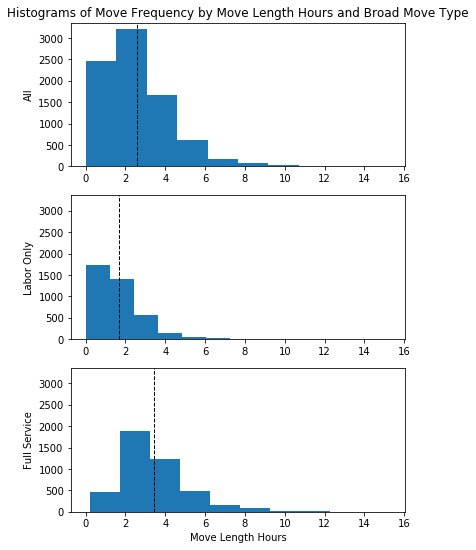

33 % of all moves run over 3 hours.
52 % of full service moves are over 3 hours long while only 11 % of labor only moves are.


In [737]:
#What do move length distributions look like by broad move type?
plt.figure(figsize=(6,9))
ax1 = plt.subplot(3,1,1)
plt.hist(df.move_length_hours)
plt.axvline(df.move_length_hours.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histograms of Move Frequency by Move Length Hours and Broad Move Type')
plt.ylabel('All')

plt.subplot(3,1,2,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.fs==0])
plt.axvline(df.move_length_hours[df.fs==0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Labor Only')

plt.subplot(3,1,3,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.fs==1])
plt.axvline(df.move_length_hours[df.fs==1].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Full Service')
plt.xlabel('Move Length Hours')

plt.show()

#Percent of moves over 3hr threshold
perc_over = round(np.mean(df.over)*100)
print(perc_over,"% of all moves run over 3 hours.")

#Percent of moves that run over 3hr threshold by broad move type
print(round((df['over'][df['fs']==1].mean())*100),"% of full service moves are over 3 hours long while only",round((df['over'][df['fs']==0].mean())*100),"% of labor only moves are.")

In [738]:
#In the future, we will want to label chart legends with "FS" and "LO", rather than the boolean values of 'fs.'
#Generating 'broad_move_type' column so that is easier.
df['broad_move_type'] = df['fs'].replace({0: 'LO', 1: 'FS'})

#### Number of Stops
It would make sense the the number of stops on a move would be driving the difference in move lengths between these two move types.

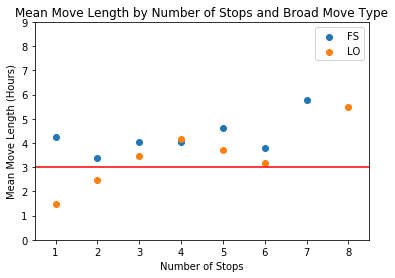

In [739]:
#Generating scatter plot of Mean Move Lengths by Number of Stops and Broad Move Type
stops = df['move_length_hours'].groupby([df['stops'],df['broad_move_type']]).mean().unstack().reset_index()
plt.scatter(stops['stops'],stops['FS'])
plt.scatter(stops['stops'],stops['LO'])
plt.title('Mean Move Length by Number of Stops and Broad Move Type')
plt.xlabel('Number of Stops')
plt.ylabel('Mean Move Length (Hours)')
plt.xlim(.5,8.5)
plt.ylim(0,max(max(stops['LO']),max(stops['FS'])))
plt.xticks(np.arange(1, 9, step=1))
plt.axhline(y=3, xmin=0, xmax=1, hold=None, color="red")
plt.legend()
plt.show()

It appears that mean move length is largely driven by number of stops, but for a given number of stops, the mean lengths of FS moves still tend to be longer than LO moves'. 

#### Move Types
In addition to "broad move types," Bellhops has a more granualar category of moves simply called "move types." There are 5 we included in this analysis:
* gopher - This is the move type that represents FS moves, multi-location moves where Bellhops provides a truck. All other move types represent LO moves.
* atob - These are multilocation moves where Bellhops does not provide a truck. The customers rent and driver trucks themselves.
* loading - Bellhops moves a customer out of a location (by loading a truck/pod/etc.)
* unloading - Bellhops moves a customer into a new location (by unloading a truck/pod/etc.)
* inhouselabor - Bellhops is not necessarily moving a customer from one location to the next, but rather moving items within a home. 

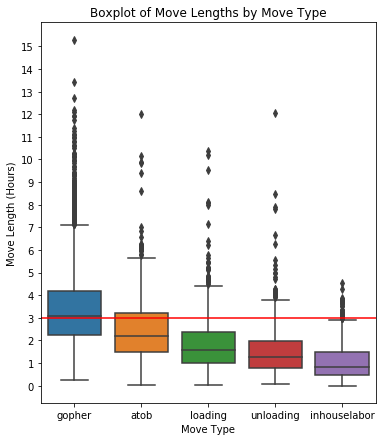

In [740]:
#Generating a boxplot of move lengths by move type.
plt.figure(figsize=(6,7))
ax = sns.boxplot(x="move_type", y="move_length_hours", order=["gopher", "atob","loading","unloading","inhouselabor"], data=df)
ax.set_title('Boxplot of Move Lengths by Move Type')
ax.set_ylabel('Move Length (Hours)')
ax.set_xlabel('Move Type')
plt.yticks(np.arange(0, max(df.move_length_hours), step=1))
plt.axhline(y=3, xmin=0, xmax=1, hold=None, color="red")
plt.show()

There do seem to be large differences in move lengths between variouse move types. Part of this is explained by the number of stops. (FS/'gopher' and 'atob' have at least two stops, the rest usualy only have one stop.) FS/gopher is the largest offender for running over 3 hours. A to b is the only other move type with the 3 hour mark within it's inner-quartile range. In house labor is the shortest move type, with more than 75% of it's moves below the 3 hours mark.

#### Markets


It's no surprise that markets have different mean move lengths as well as different mean move lengths for each broad move type. However, a relationship between mean move length for fs and lo moves would suggest that there is something systematic about a particular market makes moves longer or shorter. 

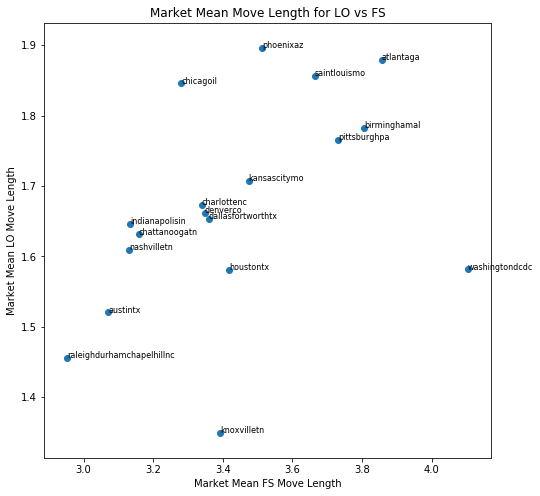

In [741]:
#Bellhops has a hunch that there are persistent move length differences among markets. Here are mean move lengths by market and move type.
ml = pd.crosstab(df.market, df.fs, values=df.move_length_hours, aggfunc=np.mean)

ml = ml.sort_values(1,ascending=False)

#Removing any obviouse an outliers.
mla = ml[ml[0] < 4]

#Reseting the index for easier plotting
mla.reset_index(inplace=True)

#Scatter plot
plt.figure(figsize=(8,8))
plt.scatter(mla[1],mla[0])
plt.title('Market Mean Move Length for LO vs FS')
plt.xlabel('Market Mean FS Move Length')
plt.ylabel('Market Mean LO Move Length')

for i, market in enumerate(mla.market):
    plt.annotate(mla.market[i], (mla[1][i],mla[0][i]), fontsize=8)
plt.show()

It does seem like mean move length for FS and LO for a market are positively correlated. There could be many stories that support this hypothesis. Maybe customers tend to have more belongings in some markets, maybe in some markets Bellhops' movers tend to work more efficiently, maybe in some markets there are demographic or geographic difference that make moves take longer. We will attempt to uncover the latter by looking at the relationship bettwen population density and move length below.

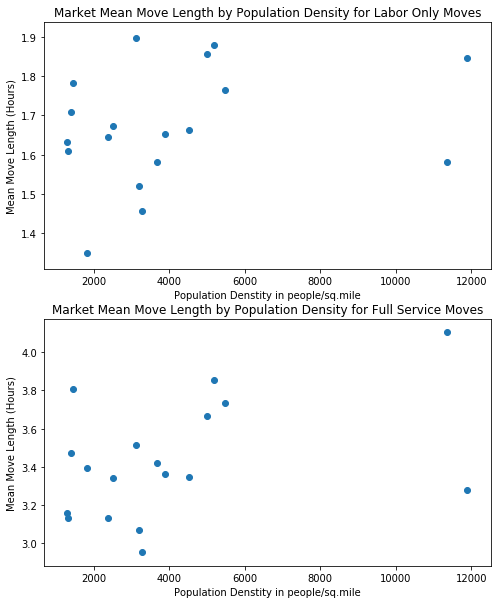

In [742]:
#Are these market specific differences driven by population density?
pop = pd.DataFrame(df['pop_density'].groupby(df['market']).mean())
ml_pop = ml.join(pop)

plt.figure(figsize=(8,10))
ax1 = plt.subplot(2,1,1)
plt.scatter(ml_pop.pop_density,[ml_pop[0]])
plt.title('Market Mean Move Length by Population Density for Labor Only Moves')
plt.xlabel('Population Denstity in people/sq.mile')
plt.ylabel('Mean Move Length (Hours)')

plt.subplot(2,1,2,sharex=ax1)
plt.scatter(ml_pop.pop_density,[ml_pop[1]])
plt.title('Market Mean Move Length by Population Density for Full Service Moves')
plt.xlabel('Population Denstity in people/sq.mile')
plt.ylabel('Mean Move Length (Hours)')
plt.show()


There is a small sample size, less than 20 markets, but both population density seems to be positively correlated move length for both FS and LO moves.

#### Drive Time Between Waypoints
Intuitively, you would think that every additional minute spent driving between waypoints would increase move length by roughly a minute.

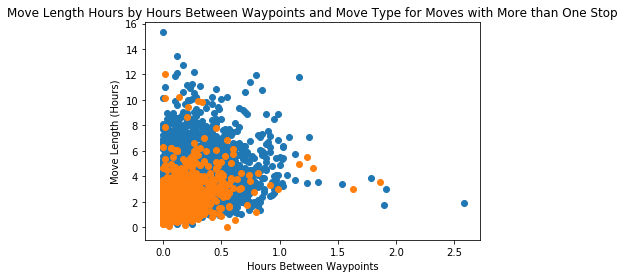

In [743]:
#Generating scatter plot for Move Length and Hours Between Waypoints
plt.scatter(df['hours_between_waypoints'][(df['fs']==1) & (df['stops']>1)],df['move_length_hours'][(df['fs']==1) & (df['stops']>1)])
plt.scatter(df['hours_between_waypoints'][(df['fs']==0) & (df['stops']>1)],df['move_length_hours'][(df['fs']==0) & (df['stops']>1)])
plt.title('Move Length Hours by Hours Between Waypoints and Move Type for Moves with More than One Stop')
plt.ylabel('Move Length (Hours)')
plt.xlabel('Hours Between Waypoints')
plt.show()

While it does look like there is a positive correlation, the relationship isn't extremely clear here. Noise caused by other factor swamps the impact visually.

#### Flights of Stairs
It would make sense to think that all else constant, an additional flight of stairs on a move would increase move length.

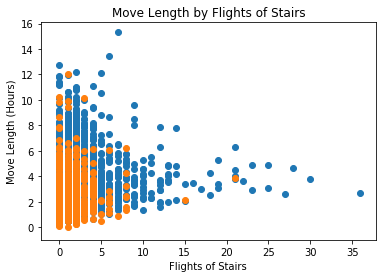

In [744]:
#Scatter plot for flights of stairs
plt.scatter(df['flights_of_stairs'][(df['fs']==1) & (df['stops']>1)],df['move_length_hours'][(df['fs']==1) & (df['stops']>1)])
plt.scatter(df['flights_of_stairs'][(df['fs']==0) & (df['stops']>1)],df['move_length_hours'][(df['fs']==0) & (df['stops']>1)])
plt.title('Move Length by Flights of Stairs')
plt.xlabel('Flights of Stairs')
plt.ylabel('Move Length (Hours)')
plt.show()

Similarly to the Drive Time Between Waypoints Scatter, move length does seem to be positively correlated with flights of stairs.

### Additional Feature Engineering

In [745]:
#Add a column for correct booked man hours
df['even_base'] = np.where(np.floor(df['executed_man_hours'])%2==0,1,0)
df['small_mins'] = np.where(df['executed_man_hours'] - np.floor(df['executed_man_hours'])<= .5, 1, 0)
df['correct_booked_man_hours'] = np.where((df['even_base']==1) & (df['small_mins'] == 1), np.floor(df['executed_man_hours']/2)*2,np.ceil(df['executed_man_hours']/2)*2 )

#Adding columns that are combinations of columns
df['second_stop'] = np.where(df['stops'] >=2,1,0)
df['extra_stop'] = np.where(((df['fs']==1)|(df['move_type']=='atob')), df.stops-2, df.stops-1)
df['extra_hop'] = np.where(df['order_total_spots'] >2,df['order_total_spots'] - 2,0)
df['web_extra_hop'] = np.where((df['order_total_spots'] >2) & (df['phone'] == 1),df['order_total_spots'] - 2,0)
df['extra_rooms'] = np.where(df['rooms'] > 1,df['rooms']-1,0)
df['vd'] = np.where(df['pop_density']>5000,1,0)
df['pop_density'] = df['pop_density']/4000
df['coupon'] = np.where(df['coupon_amount'] > 0,1,0)
df['rooms_stops'] = df.rooms*df.stops

#Adding interaction columns
df['fs_dense'] = df['fs']*df['dense']
df['fs_rooms'] = df['fs']*df['rooms']
df['dense_apt'] = np.where((df['property_type_name']=='Apartment/Condo') & (df['dense']==1),1,0)

df['second_stop_extra_rooms'] = df['second_stop']*df['extra_rooms']
df['second_stop_dense'] = df['second_stop']*df['dense']
df['second_stop_extra_rooms_dense'] = df['second_stop']*df['extra_rooms']*df['dense']

df['vd_rooms'] = df['vd']*df['rooms']
df['house_rooms'] = df['house']*df['rooms']
df['rooms_stairs'] = df['rooms']*df['flights_of_stairs']
df['rooms_stairs_stops'] = df['rooms']*df['flights_of_stairs']* df['stops']
df['rooms_squared'] = df['rooms']*df['rooms']



In [746]:
#List of market dummies, leaving Atlanta out
market_dummies = ['mkt_austintx', 'mkt_birminghamal',
       'mkt_charlottenc', 'mkt_chattanoogatn', 'mkt_chicagoil',
       'mkt_dallasfortworthtx', 'mkt_denverco', 'mkt_houstontx',
       'mkt_indianapolisin', 'mkt_kansascitymo', 'mkt_knoxvilletn',
       'mkt_nashvilletn', 'mkt_phoenixaz', 'mkt_pittsburghpa',
       'mkt_raleighdurhamchapelhillnc', 'mkt_saintlouismo',
       'mkt_washingtondcdc']

#List of move type dummies, leaving unloading out
move_type_dummies = ['mt_atob', 'mt_gopher', 'mt_inhouselabor','mt_loading']

## Inferential Statistics

In this section, I evaluate the correlation between all features in the data set and the target variable and generate a pair plot of the ones that are most strongly correlated to the target variable. Then I generate a correlation matrix between the features to inspect which are most correlated with each other to highlight which ones I should potentially avoid including in a model together. Finally, I plug a couple combinations of features into models as a first pass at assessing explanatory power.

In [ ]:
#Generate correlation matrix and take the absolute values
c = df.corr().abs()

#Take the colum that represent correlations with the independent variable and sort by  largest correlation
d = c.over.sort_values(ascending=False)

#Display all items in series
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(d)

over                             1.000000
move_length_hours                0.780753
executed_man_hours               0.634859
correct_booked_man_hours         0.632419
booked_man_hours                 0.481293
fs_rooms                         0.456562
second_stop                      0.433679
mt_gopher                        0.433084
min_billable_man_hours           0.433084
fs                               0.433084
stops                            0.405100
rooms_stops                      0.397064
minutes_between_waypoints        0.386389
hours_between_waypoints          0.386389
second_stop_extra_rooms          0.351060
miles_between_waypoints          0.326896
nps_score                        0.317653
nps_detractor                    0.296374
nps_promoter                     0.296233
rooms_stairs_stops               0.272975
extra_hop                        0.262708
order_total_spots                0.261028
max_late_clock_in_hours          0.240760
rooms_stairs                     0

In [ ]:
#Select the target variable and features that are most highly correlated with the target variable
pair_vars = ['over', 'booked_man_hours','fs','fs_rooms','stops','rooms_stairs_stops','rooms_stairs','max_late_clock_in_hours','extra_hop','sum_prev_late_rate','num_bad_star_hops','hour_of_day']
sns.pairplot(df, vars= pair_vars, hue='fs',kind="reg", plot_kws={'scatter_kws': {'alpha': 0.1}})


In [ ]:
#Plotting correlation matrix to easily visualize which of the most highly correlated features are highly correlated with each other

#Generate and show a correlation matrix
df_corr = df[pair_vars]
plt.matshow(df_corr.corr())
 
#Add x labels
x_pos = np.arange(len(pair_vars))
plt.xticks(x_pos,pair_vars, rotation=90)

#Add y labels
y_pos = np.arange(len(pair_vars))
plt.yticks(y_pos,pair_vars)

#Show
plt.show()

In [ ]:
import statsmodels.formula.api as smf
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

df_log = df[(df.hours_between_waypoints.notnull())]
x_cols = ['booked_man_hours','fs_rooms','hours_between_waypoints','residence','sum_prev_late_rate','num_bad_star_hops','hour_of_day','coupon']+ market_dummies + move_type_dummies

X = df_log[x_cols]
y = df_log['over']

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
result.summary()

**Thoughts**

All features but sum_prev_late_rate, mkt_washingtondcdc, and mt_loading  are significant at the 5% level. However, unfortunately, the psuedo R squared value is pretty low.


In [ ]:
df.to_csv('move_est_plus.csv')